In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor


random_state=7

%matplotlib inline
pd.set_option('display.max_columns', 500)

# Reading Data

In [162]:
train=pd.read_csv('input/train.csv', parse_dates=['timestamp'])
test=pd.read_csv('input/test.csv', parse_dates=['timestamp'])
macro=pd.read_csv('input/macro.csv', parse_dates=['timestamp'])


test_id=test['id']

print('The shape of training data is', train.shape)
print('The shape of test data is', test.shape)
#print('The shape of macro data is', macro.shape)


#fts contains the feature names (exclude id and year)
fts=list(train.columns[1:-1])

The shape of training data is (30471, 292)
The shape of test data is (7662, 291)


In [163]:
# sample the training data
trainsub=train[train.timestamp<'2015-01-01']
trainsub=trainsub[trainsub.product_type=='Investment']
print('shape of the investment type', trainsub.shape)

ind_1m=trainsub[trainsub.price_doc <= 1000000].index
ind_2m=trainsub[trainsub.price_doc == 2000000].index
ind_3m=trainsub[trainsub.price_doc==3000000].index

print('num of ind_1m', len(ind_1m))
print('num of ind_2m', len(ind_2m))
print('num of ind_3m', len(ind_3m))

train_index=set(train.index.copy())

for ind, gap in zip([ind_1m, ind_2m, ind_3m], [10, 3, 2]):
    ind_set=set(ind)
    ind_set_cut=ind.difference(set(ind[::gap]))
    
    train_index=train_index.difference(ind_set_cut)
    
train=train.loc[train_index]
train['price_doc']=np.log(train['price_doc']+1)

shape of the investment type (17693, 292)
num of ind_1m 930
num of ind_2m 680
num of ind_3m 292


In [164]:
#get rid of price outliers
train=train[(train.price_doc>13.5)&(train.price_doc<18.5)]

n_train=train.shape[0]
n_test=test.shape[0]


print('number of train', n_train)
print('number of test', n_test)

number of train 29030
number of test 7662


# Look at Nas in important features

In [165]:
#if build year if larger than 2019 or smaller than 1800 change them to median
train['build_year'][(train.build_year<1800) | (train.build_year>2019)]=train.build_year.median()

#if full sq is zero, assign it to median
train['full_sq'][train.full_sq==0]=train.full_sq.median()

#if max_floor is zero, assign it to median
train['max_floor'][train.max_floor==0]=train.full_sq.median()

#preschool quota is zero assign it to median
train['preschool_quota'][train.preschool_quota==0]=train.preschool_quota.median()

#if kitch_sq is too large or larger than life_sq use 20% full_sq
train['kitch_sq'][(train.kitch_sq > 50) | (train.kitch_sq > train.life_sq)]=kitch_est=train['full_sq'][(train.kitch_sq > 50) | (train.kitch_sq > train.life_sq)]*0.2

#if life_sq is na or life_sq is too small or too large, change it to 0.7 full_sq
#train['life_sq'][train.life_sq.isnull()]=train['full_sq'][train.life_sq.isnull()]*0.7
#train['life_sq'][(train.life_sq<0.1*train.full_sq)| (train.life_sq>train.full_sq)] = train['full_sq'][(train.life_sq<0.1*train.full_sq)| (train.life_sq>train.full_sq)]

#fill no data with satisfactory
train['ecology'][train.ecology=='no data']='satisfactory'

In [166]:
#if build year if larger than 2019 or smaller than 1800 change them to median
test['build_year'][(test.build_year<1800) | (test.build_year>2019)]=test.build_year.median()

#if full sq is zero, assign it to median
test['full_sq'][test.full_sq==0]=test.full_sq.median()

#if max_floor is zero, assign it to median
test['max_floor'][test.max_floor==0]=test.full_sq.median()

#preschool quota is zero assign it to median
test['preschool_quota'][test.preschool_quota==0]=test.preschool_quota.median()

#if kitch_sq is too large or larger than life_sq use 20% full_sq
test['kitch_sq'][(test.kitch_sq > 50) | (test.kitch_sq > test.life_sq)]=kitch_est=test['full_sq'][(test.kitch_sq > 50) | (test.kitch_sq > test.life_sq)]*0.2

#if life_sq is na or life_sq is too small or too large, change it to 0.7 full_sq
#test['life_sq'][test.life_sq.isnull()]=test['full_sq'][test.life_sq.isnull()]*0.7
#test['life_sq'][(test.life_sq<0.1*test.full_sq)| (test.life_sq>test.full_sq)] = test['full_sq'][(test.life_sq<0.1*test.full_sq)| (test.life_sq>test.full_sq)]

#fill no data with satisfactory
test['ecology'][test.ecology=='no data']='satisfactory'

/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithC

In [167]:
print('num of train', train.shape[0])
print('num of test', test.shape[0])

train_with_life=train[~train.life_sq.isnull()]
print('number of train with life_sq', train_with_life.shape[0])

train_no_life=train[train.life_sq.isnull()]
train_no_life=train_no_life.drop(['life_sq'], axis=1)
print('number of train without life_sq', train_no_life.shape[0])


test_with_life=test[~test.life_sq.isnull()]
print('number of test with life_sq', test_with_life.shape[0])

test_no_life=test[test.life_sq.isnull()]
test_no_life=test_no_life.drop(['life_sq'], axis=1)
print('number of test without life_sq', test_no_life.shape[0])


target_with_life=train_with_life.price_doc.values
target_no_life=train_no_life.price_doc.values

train_with_life=train_with_life.drop(['price_doc'], axis=1)
train_no_life=train_no_life.drop(['price_doc'], axis=1)

print('number of target with life', len(target_with_life))
print('number of target no life', len(target_no_life))


selected_f=["timestamp", "balance_trade_growth", "eurrub", "average_provision_of_build_contract", 
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", 
"mortgage_rate", "income_per_cap", "rent_price_4+room_bus","museum_visitis_per_100_cap","apartment_build"]

selected_macro=macro[selected_f]

num of train 29030
num of test 7662
number of train with life_sq 22649
number of train without life_sq 6381
number of test with life_sq 6486
number of test without life_sq 1176
number of target with life 22649
number of target no life 6381


In [168]:
train_with_life=pd.merge(train_with_life, selected_macro, how='left', on='timestamp')

#Add month-year count
month_year = (train_with_life.timestamp.dt.month + train_with_life.timestamp.dt.year*100)
month_year_cnt_map=month_year.value_counts().to_dict()
train_with_life['month_year_cnt']=month_year.map(month_year_cnt_map)

#Add week-year count
week_year=(train_with_life.timestamp.dt.week + train_with_life.timestamp.dt.year*100)
week_year_cnt_map=week_year.value_counts().to_dict()
train_with_life['week_year_cnt']=week_year.map(week_year_cnt_map)

#Add month and day-of-week
train_with_life['month']=train_with_life.timestamp.dt.month
train_with_life['dow']=train_with_life.timestamp.dt.month

print('shape of the merged train_with_life', train_with_life.shape)



train_no_life=pd.merge(train_no_life, selected_macro, how='left', on='timestamp')

#Add month-year count
month_year = (train_no_life.timestamp.dt.month + train_no_life.timestamp.dt.year*100)
month_year_cnt_map=month_year.value_counts().to_dict()
train_no_life['month_year_cnt']=month_year.map(month_year_cnt_map)

#Add week-year count
week_year=(train_no_life.timestamp.dt.week + train_no_life.timestamp.dt.year*100)
week_year_cnt_map=week_year.value_counts().to_dict()
train_no_life['week_year_cnt']=week_year.map(week_year_cnt_map)

#Add month and day-of-week
train_no_life['month']=train_no_life.timestamp.dt.month
train_no_life['dow']=train_no_life.timestamp.dt.month

print('shape of the merged train_no_life', train_no_life.shape)


test_with_life=pd.merge(test_with_life, selected_macro, how='left', on='timestamp')

#Add month-year count
month_year = (test_with_life.timestamp.dt.month + test_with_life.timestamp.dt.year*100)
month_year_cnt_map=month_year.value_counts().to_dict()
test_with_life['month_year_cnt']=month_year.map(month_year_cnt_map)

#Add week-year count
week_year=(test_with_life.timestamp.dt.week + test_with_life.timestamp.dt.year*100)
week_year_cnt_map=week_year.value_counts().to_dict()
test_with_life['week_year_cnt']=week_year.map(week_year_cnt_map)

#Add month and day-of-week
test_with_life['month']=test_with_life.timestamp.dt.month
test_with_life['dow']=test_with_life.timestamp.dt.month

print('shape of the merged test_with_life', test_with_life.shape)


test_no_life=pd.merge(test_no_life, selected_macro, how='left', on='timestamp')

#Add month-year count
month_year = (test_no_life.timestamp.dt.month + test_no_life.timestamp.dt.year*100)
month_year_cnt_map=month_year.value_counts().to_dict()
test_no_life['month_year_cnt']=month_year.map(month_year_cnt_map)

#Add week-year count
week_year=(test_no_life.timestamp.dt.week + test_no_life.timestamp.dt.year*100)
week_year_cnt_map=week_year.value_counts().to_dict()
test_no_life['week_year_cnt']=week_year.map(week_year_cnt_map)

#Add month and day-of-week
test_no_life['month']=test_no_life.timestamp.dt.month
test_no_life['dow']=test_no_life.timestamp.dt.month

print('shape of the merged test_no_life', test_no_life.shape)



shape of the merged train_with_life (22649, 307)
shape of the merged train_no_life (6381, 306)
shape of the merged test_with_life (6486, 307)
shape of the merged test_no_life (1176, 306)


In [169]:
n_train_with_life=train_with_life.shape[0]
all_with_life=pd.concat([train_with_life, test_with_life])

all_with_life=pd.get_dummies(all_with_life)
all_with_life['year']=all_with_life['timestamp'].dt.year.astype(int)
all_with_life.drop('timestamp', axis=1, inplace=True)


train_with_life=all_with_life.iloc[:n_train_with_life, :]
print('train_with_life shape after get_dummies', train_with_life.shape)
test_with_life=all_with_life.iloc[n_train_with_life:, :]
print('test_with_life shape after get_dummies', test_with_life.shape)



n_train_no_life=train_no_life.shape[0]
all_no_life=pd.concat([train_no_life, test_no_life])

all_no_life=pd.get_dummies(all_no_life)
all_no_life['year']=all_no_life['timestamp'].dt.year.astype(int)
all_no_life.drop('timestamp', axis=1, inplace=True)


train_no_life=all_no_life.iloc[:n_train_no_life, :]
print('train_no_life shape after get_dummies', train_no_life.shape)
test_no_life=all_no_life.iloc[n_train_no_life:, :]
print('test_no_life shape after get_dummies', test_no_life.shape)



train_with_life shape after get_dummies (22649, 467)
test_with_life shape after get_dummies (6486, 467)
train_no_life shape after get_dummies (6381, 416)
test_no_life shape after get_dummies (1176, 416)


In [170]:
id_train_with_life=train_with_life.id.values
id_train_no_life=train_no_life.id.values

id_test_with_life=test_with_life.id.values
id_test_no_life=test_no_life.id.values

print('id in train with life', len(id_train_with_life))
print('id in train no life', len(id_train_no_life))
print('id in test with life', len(id_test_with_life))
print('id in test no life', len(id_test_no_life))


train_with_life.drop('id', axis=1, inplace=True)
train_no_life.drop('id', axis=1, inplace=True)
test_with_life.drop('id', axis=1, inplace=True)
test_no_life.drop('id', axis=1, inplace=True)

id in train with life 22649
id in train no life 6381
id in test with life 6486
id in test no life 1176


/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be s

In [154]:
%store id_train_no_life

Stored 'id_train_no_life' (ndarray)


# Fill NaS with Median

In [ ]:
# #when using get_dummies the Nan in categorical data are ignored. The possible Nan are numbers. fill them with mean
# print('number of NaN in train and test', data.isnull().sum().sum())

# data=data.fillna(data.median())

# print('number of NaN in train and test', data.isnull().sum().sum())

In [12]:
# #Add more features:

# #relative floor
# data['relative_floor']=data['floor'].div(data['max_floor'].astype(float))

# #relative life_sq
# data['relative_life_sq']=data['life_sq'].div(data['full_sq'].astype(float))

# #ratio of number of pupils and preschool seats
# data['ratio_preschool']=data['children_preschool'].div(data['preschool_quota'].astype(float))

# #ratio of number of pupils and school seats
# data['ratio_school']=data['children_school'].div(data['school_quota'].astype(float))

# #young porpulation ratio
# data['ratio_young']=data['young_all'].div(data['full_all'].astype(float))

# Try standardscaler before fitting

In [13]:
# from sklearn.preprocessing import StandardScaler
# col_names=list(data.columns)

# ss=StandardScaler(with_mean=False, with_std=True)
# data_std=ss.fit_transform(data)
# data_std=pd.DataFrame(data_std, columns=col_names)

# train_std=data_std.iloc[:n_train, :]
# test_std=data_std.iloc[n_train :, :]

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
#train rf:

rf=RandomForestRegressor(n_estimators=800, n_jobs=-1, 
                         max_features='auto', max_depth=10, verbose=1)
rf.fit(train_std, target)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 27.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=800, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False)

In [57]:
rf_importance=rf.feature_importances_
rf_dict=dict()

for f, importance in zip (train_std.columns, rf_importance):
    rf_dict[f]=importance
    
rf_dict=sorted(rf_dict.items(), key=operator.itemgetter(1), reverse=True)
rf_dict=pd.DataFrame(rf_dict, columns=['feature', 'score'])
#rf_dict.to_csv(path_or_buf='submissions/0527/rf_feature_importance.csv')

importance_rate=0.01
rf_index=rf_dict[rf_dict.score>importance_rate*rf_dict.score.max()].feature.values
print('number of rf_index', len(rf_index))

number of rf_index 14


In [58]:
rf_new=RandomForestRegressor(n_estimators=800, n_jobs=-1,
                            max_features='auto', max_depth=10, verbose=1)
rf_new.fit(train_std[rf_index], target)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=800, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False)

In [59]:
in_rf=rf_new.predict(train_std[rf_index])
in_rf=np.exp(in_rf)-1
insample_rf=pd.DataFrame({'id': train.id, 'price_doc_rf': in_rf})
insample_rf.to_csv(path_or_buf='ensamble/rf_train_0.01importance.csv', index=False)

pre_rf=rf_new.predict(test_std[rf_index])
pre_rf=np.exp(pre_rf)-1

submission=pd.DataFrame({'id': test_id, 'price_doc': pre_rf})
submission.to_csv(path_or_buf='ensamble/170527subission_rf_with_12macro_cleandata_8newfeature.cs_0.01importv',index=False)
submission.head()

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.7s finished


,id,price_doc
0,30474,5101030.540339
1,30475,8362429.300093
2,30476,6274865.593472
3,30477,6374278.885423
4,30478,5145806.001251


# XGBOOST with life_sq

In [143]:
import xgboost as xgb

In [171]:
from sklearn.model_selection import train_test_split
train_part, val_train, target_part, val_target=train_test_split(train_no_life, target_no_life, test_size=0.2, 
                                                              random_state=random_state)
print('shape of train_part', train_part.shape)
print('shape of target_part', target_part.shape)
print('shape of val_train', val_train.shape)
print('shape of val_target', val_target.shape)

shape of train_part (5104, 415)
shape of target_part (5104,)
shape of val_train (1277, 415)
shape of val_target (1277,)


In [172]:
dtrain=xgb.DMatrix(train_part, target_part)
dval=xgb.DMatrix(val_train, val_target)

xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0,
    'lambda': 100,
    'base_score': 7
}

model=xgb.train(xgb_params, dtrain, num_boost_round=2000, 
                evals=[(dval, 'validation')], early_stopping_rounds=20,
               verbose_eval=100)
num_boost_round=model.best_iteration

[0]	validation-rmse:8.40512
Will train until validation-rmse hasn't improved in 20 rounds.
[100]	validation-rmse:1.25783
[200]	validation-rmse:0.308998
[300]	validation-rmse:0.171962
[400]	validation-rmse:0.14303
[500]	validation-rmse:0.1325
[600]	validation-rmse:0.127193
[700]	validation-rmse:0.12407
[800]	validation-rmse:0.121974
[900]	validation-rmse:0.120612
[1000]	validation-rmse:0.119559
[1100]	validation-rmse:0.118677
[1200]	validation-rmse:0.117974
[1300]	validation-rmse:0.117334
[1400]	validation-rmse:0.116949
[1500]	validation-rmse:0.116495
[1600]	validation-rmse:0.116204
[1700]	validation-rmse:0.115925
[1800]	validation-rmse:0.115749
[1900]	validation-rmse:0.115586
Stopping. Best iteration:
[1943]	validation-rmse:0.115494



In [173]:
score=model.get_fscore()
score=sorted(score.items(), key=operator.itemgetter(1), reverse=True)
score=pd.DataFrame(score, columns=['feature', 'fscore'])
#score.to_csv(path_or_buf='submissions/scores/xgb_score_with_life.csv')

importance_rate=0.03
f_index=score[score.fscore>importance_rate*score.fscore.max()].feature.values
print('number of f_index', len(f_index))

number of f_index 52


In [174]:
train_select=pd.DataFrame(train_part)
train_select=train_select[f_index]

val_select=pd.DataFrame(val_train)
val_select=val_select[f_index]

dtrain_select=xgb.DMatrix(train_select, target_part)
dval_select=xgb.DMatrix(val_select, val_target)

xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0,
    'lambda': 100,
    'base_score': 7
}

model=xgb.train(xgb_params, dtrain_select, num_boost_round=2000, 
                evals=[(dval_select, 'validation')], early_stopping_rounds=20,
               verbose_eval=100)
num_boost_round=model.best_iteration

[0]	validation-rmse:8.40512
Will train until validation-rmse hasn't improved in 20 rounds.
[100]	validation-rmse:1.25791
[200]	validation-rmse:0.316411
[300]	validation-rmse:0.175749
[400]	validation-rmse:0.147149
[500]	validation-rmse:0.136482
[600]	validation-rmse:0.13081
[700]	validation-rmse:0.127344
[800]	validation-rmse:0.124941
[900]	validation-rmse:0.123152
[1000]	validation-rmse:0.121717
[1100]	validation-rmse:0.120724
[1200]	validation-rmse:0.119909
[1300]	validation-rmse:0.119305
[1400]	validation-rmse:0.118691
[1500]	validation-rmse:0.118277
[1600]	validation-rmse:0.117863
[1700]	validation-rmse:0.117524
[1800]	validation-rmse:0.11729
Stopping. Best iteration:
[1843]	validation-rmse:0.117193



In [125]:
#train xgb with full train data
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0,
    'lambda': 100,
    'base_score': 7
}

Ddata_with_life=xgb.DMatrix(train_with_life[f_index], target_with_life)

#full_model=xgb.train(xgb_params, Ddata_std, num_boost_round=num_boost_round,
#                    verbose_eval=100)
#xgb.cv(xgb_params, Ddata_with_life, num_boost_round=3000, nfold=5, 
#       verbose_eval=100, early_stopping_rounds=20)

# Ddata_no_life=xgb.DMatrix(train_no_life[f_index], target_no_life)

# xgb.cv(xgb_params, Ddata_no_life, num_boost_round=3000, nfold=5, 
#        verbose_eval=100, early_stopping_rounds=20)

[0]	train-rmse:8.38846+0.000667572	test-rmse:8.38846+0.002664
[100]	train-rmse:1.23687+0.000628648	test-rmse:1.23697+0.00248685
[200]	train-rmse:0.290124+0.00109729	test-rmse:0.294973+0.00804937
[300]	train-rmse:0.141698+0.0010618	test-rmse:0.154689+0.00687291
[400]	train-rmse:0.109516+0.00113303	test-rmse:0.128655+0.00555067
[500]	train-rmse:0.0966796+0.00103821	test-rmse:0.120088+0.00612473
[600]	train-rmse:0.0891986+0.00101084	test-rmse:0.115664+0.00645667
[700]	train-rmse:0.083918+0.00101857	test-rmse:0.112849+0.00672934
[800]	train-rmse:0.0798492+0.000969576	test-rmse:0.11094+0.00690757
[900]	train-rmse:0.0764308+0.000958545	test-rmse:0.109514+0.00705437
[1000]	train-rmse:0.0735966+0.000990778	test-rmse:0.108497+0.00724759
[1100]	train-rmse:0.0711066+0.00104619	test-rmse:0.107691+0.00736205
[1200]	train-rmse:0.0688202+0.00104161	test-rmse:0.106968+0.0074417
[1300]	train-rmse:0.066721+0.00104575	test-rmse:0.106398+0.00747586
[1400]	train-rmse:0.0647754+0.00105266	test-rmse:0.105905

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,8.388456,0.002664,8.388456,0.000668
1,8.225117,0.002716,8.225117,0.000612
2,8.064964,0.002738,8.064965,0.000584
3,7.907964,0.002743,7.907964,0.000574
4,7.754065,0.002778,7.754065,0.000539
5,7.603146,0.002757,7.603146,0.000566
6,7.455161,0.002798,7.455162,0.000530
7,7.310066,0.002739,7.310066,0.000558
8,7.167837,0.002706,7.167837,0.000580
9,7.028414,0.002739,7.028415,0.000538


In [175]:
# Ddata_with_life=xgb.DMatrix(train_with_life[f_index], target_with_life)
# full_model_with_life=xgb.train(xgb_params, Ddata_with_life, 
#                     num_boost_round=num_boost_round, verbose_eval=100)

Ddata_no_life=xgb.DMatrix(train_no_life[f_index], target_no_life)
full_model_no_life=xgb.train(xgb_params, Ddata_no_life, 
                    num_boost_round=num_boost_round,verbose_eval=100)

In [160]:
Dtest_with_life=xgb.DMatrix(test_with_life[f_index])
pre_with_life=full_model_with_life.predict(Dtest_with_life)
pre_with_life=pd.DataFrame({'id': id_test_with_life, 'price_doc': pre_with_life})
pre_with_life.head()

,id,price_doc
0,30474,15.498250
1,30476,15.470566
2,30477,15.519384
3,30478,15.296707
4,30482,15.376550


In [176]:
Dtest_no_life=xgb.DMatrix(test_no_life[f_index])
pre_no_life=full_model_no_life.predict(Dtest_no_life)
pre_no_life=pd.DataFrame({'id': id_test_no_life, 'price_doc': pre_no_life})
pre_no_life.head()

,id,price_doc
0,30475,15.992988
1,30479,16.141916
2,30480,15.361623
3,30481,15.315285
4,30484,15.619556


In [185]:
pre_full=pd.concat([pre_with_life, pre_no_life])
pre_full['price_doc']=np.exp(pre_full.price_doc)-1
pre_full.sort(columns='id', inplace=True)
pre_full.to_csv(path_or_buf='170529seperatre_life.csv', index=False)

/home/xinlin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


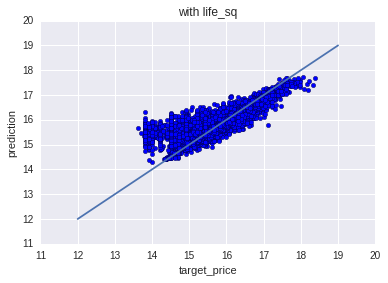

In [152]:
plt.scatter(target_with_life, full_model_with_life.predict(Ddata_with_life))
plt.plot([12,19], [12, 19])
plt.xlabel('target_price')
plt.ylabel('prediction')
plt.title('with life_sq')
#plt.savefig('with_life_sq.pdf')

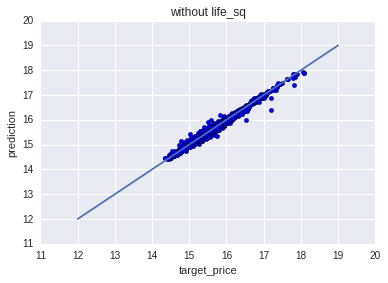

In [153]:
plt.scatter(target_no_life, full_model_no_life.predict(Ddata_no_life))
plt.plot([12,19], [12, 19])
plt.xlabel('target_price')
plt.ylabel('prediction')
plt.title('without life_sq')
plt.savefig('plots/without_life_sq.pdf')

In [119]:
in_xgb=full_model.predict(Ddata_std)
in_xgb=np.exp(in_xgb)-1
insample_xgb=pd.DataFrame({'id': train.id, 'price_doc_xgb': in_xgb})
insample_xgb.to_csv(path_or_buf='ensamble/xgb_train_0.03importance.csv', index=False)

dtest_std=xgb.DMatrix(test_std[f_index])
pre_xgb=full_model.predict(dtest_std)
pre_xgb=np.exp(pre_xgb)-1

submission=pd.DataFrame({'id': test_id, 'price_doc_xgb': pre_xgb})
submission.to_csv(path_or_buf='ensamble/170527subission_xgb_with_12macro_cleandata_8newfeature_0.03import.csv',index=False)
submission.head()


,id,price_doc_xgb
0,30474,5619100.0
1,30475,8844294.0
2,30476,5284690.0
3,30477,6106908.0
4,30478,5312507.5


In [118]:
pre_xgb=np.exp(pre_xgb)-1

submission=pd.DataFrame({'id': test_id, 'price_doc': pre_xgb})
submission.to_csv(path_or_buf='170525subission_xgb_with_12macro_cleandata_8newfeature_nosubsample_0.03impoartance.csv',index=False)
submission.head()

,id,price_doc
0,30474,5860943.5
1,30475,8614750.0
2,30476,4888695.5
3,30477,6142954.0
4,30478,5388001.5


# GBRT

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

GBRT_clf=GradientBoostingRegressor(n_estimators=300,learning_rate=0.03,
                                   verbose=1, random_state=random_state)

#clf.fit(train_std[f_index], target)
#clf.fit(train_std, target)

GBRT_params={'loss': ['ls', 'lad'],
            'max_features': ['auto', 'sqrt'],
            'subsample': [0.6, 0.7, 0.8, 0.9],
            'max_leaf_nodes': [7,8,9,10]}

GBRT_cv=GridSearchCV(GBRT_clf, GBRT_params, cv=5, n_jobs=-1)
GBRT_cv.fit(train_std, target)

In [96]:
GBRT_clf=GradientBoostingRegressor(n_estimators=600,learning_rate=0.02,
                                   verbose=0, random_state=random_state,
                                  subsample=0.9, max_leaf_nodes=10)

GBRT_clf.fit(train_std, target)

# pre_GBRT=GBRT_clf.predict(test_std)
# pre_GBRT=np.exp(pre_GBRT)-1

# submission=pd.DataFrame({'id': test_id, 'price_doc': pre_GBRT})
# submission.to_csv(path_or_buf='170526submission_GBRT_with_12features_cleandata_macro.csv',index=False)
# submission.head()

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=10, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=600,
             presort='auto', random_state=7, subsample=0.9, verbose=0,
             warm_start=False)

In [116]:
GBRT_dict=dict()
for f, importance in zip(train_std.columns, GBRT_clf.feature_importances_):
    GBRT_dict[f]=importance

GBRT_dict=sorted(GBRT_dict.items(), key=operator.itemgetter(1), reverse=True)
GBRT_dict=pd.DataFrame(GBRT_dict, columns=['feature', 'GBRT_score'])
GBRT_dict.to_csv(path_or_buf='submissions/scores/GBRT_score.csv')

importance_rate=0.01
GBRT_index=GBRT_dict[xgb_dict.GBRT_score>importance_rate*GBRT_dict.GBRT_score.max()].feature.values
print('number of f_index', len(GBRT_index))

number of f_index 135


In [117]:
GBRT_fullmode=GradientBoostingRegressor(n_estimators=600,learning_rate=0.02,
                                   verbose=0, random_state=random_state,
                                  subsample=0.9, max_leaf_nodes=10)

#scores = cross_val_score(GBRT_cv, train_std[GBRT_index], target, cv=5)
#print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
GBRT_fullmode.fit(train_std[GBRT_index], target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=10, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=600,
             presort='auto', random_state=7, subsample=0.9, verbose=0,
             warm_start=False)

In [118]:
in_GBRT=GBRT_fullmode.predict(train_std[GBRT_index])
in_GBRT=np.exp(in_GBRT)-1
insample_GBRT=pd.DataFrame({'id': train.id, 'price_doc_GBRT': in_GBRT})
insample_GBRT.to_csv(path_or_buf='ensamble/GBRT_train_0.03importance.csv', index=False)


pre_GBRT=GBRT_fullmode.predict(test_std[GBRT_index])
pre_GBRT=np.exp(pre_GBRT)-1

submission=pd.DataFrame({'id': test_id, 'price_doc_GBRT': pre_GBRT})
submission.to_csv(path_or_buf='ensamble/170527submission_GBRT_with_12features_macro_0.03import.csv',index=False)
submission.head()

,id,price_doc_GBRT
0,30474,5633902.113439
1,30475,8287396.831267
2,30476,5465193.683202
3,30477,5576789.089920
4,30478,5103606.320849
